In [181]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras import models
from keras import layers
from keras.layers import Attention, Bidirectional, Concatenate, Dense, Embedding, Input, LSTM, Flatten
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [2]:
# I'm working in colab - mount my google drive and set the project folder as 
# the current working directory
try:
    from google.colab import drive 
    drive.mount('/content/drive', force_remount=True)
    %cd drive/My Drive/Colab Notebooks/nlp_github/CS-6120_saulniern/project/
except:
    pass

vua_input_csv = os.path.join(os.getcwd(), 'VUA_formatted.csv')

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/nlp_github/CS-6120_saulniern/project


# Data Preparation

In [3]:
# Read VU Amsterdam corpus CSV into pandas dataframe
vua_df = pd.read_csv(vua_input_csv, encoding='latin-1')

In [4]:
# Create the input data and labels arrays
X_input = vua_df['sentence'].to_numpy()
y_input = vua_df['label'].to_numpy()
target_words = vua_df['verb'].to_numpy()
target_word_idx = vua_df['verb_idx'].to_numpy()

In [5]:
# Load GloVe embeddings into a dictionary
# Code Source: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/pretrained_word_embeddings.ipynb#scrollTo=jzqMvLHgH0PI
# GloVe Citation: Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
glove_input_file = os.path.join(os.getcwd(), 'glove.840B.300d.txt')

GloVe_dict = {}
with open(glove_input_file) as file:
    for line in file:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        GloVe_dict[word] = coefs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  # Remove the CWD from sys.path while we load stuff.


In [6]:
# Create the input text target windows
# Each input window is an 11-gram with the target verb in the center
# The windows are padded at the left and right boundaries as needed
input_windows = []
for index,text in enumerate(X_input):
    tokens = text.split()
    target_index = target_word_idx[index]
    window_start = target_index - 5
    window_end = target_index + 6
    if window_start < 0:
        pad_count = abs(0 - window_start)
        pad = ['[PAD]'] * pad_count
        tokens = pad + tokens
        target_index += pad_count
    if window_end > len(tokens):
        pad_count = abs(window_end - len(tokens))
        pad = ['[PAD]'] * pad_count
        tokens += pad
    window_start = target_index - 5
    window_end = target_index + 6
    window = tokens[window_start:window_end]
    input_windows.append(window)

In [7]:
# Create text snippets from windows
window_texts = []
for window in input_windows:
    window_texts.append(' '.join(window))

In [8]:
# Create vocab and integer-encode windowed input
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(window_texts)
vocab_size = len(text_tokenizer.word_index) + 1
encoded_window_input = text_tokenizer.texts_to_sequences(window_texts)

In [9]:
# Create a vocab and integer-encoding for the raw (non-windowed) input
raw_text_tokenizer = Tokenizer()
raw_text_tokenizer.fit_on_texts(X_input)
raw_vocab_size = len(raw_text_tokenizer.word_index) + 1
encoded_raw_text = raw_text_tokenizer.texts_to_sequences(X_input)
max_raw_input_size = max(len(sentence) for sentence in encoded_raw_text)

In [10]:
# Convert encoded raw input to numpy array
encoded_array_raw_input = tf.keras.preprocessing.sequence.pad_sequences(encoded_raw_text, maxlen=max_raw_input_size)

In [11]:
# Convert encoded window input to numpy array
encoded_array_window_input = tf.keras.preprocessing.sequence.pad_sequences(encoded_window_input, maxlen=11)

In [12]:
def gloveEmbeddingMatrix(vocab_size, text_tokenizer, GloVe_dict):
    """
    Create GloVe embedding matrix given a vocab size, fitted text tokenizer, 
    and dict of 300d GloVe embeddings.

    Source: Jason Brownlee, https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
    """
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, index in text_tokenizer.word_index.items():
        embedding_vector = GloVe_dict.get(word)
        if embedding_vector is not None and len(embedding_vector) == 300:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = GloVe_dict.get('unk')
    return embedding_matrix

In [13]:
# Create GloVe embedding matrix for windowed input
embedding_matrix = gloveEmbeddingMatrix(vocab_size, text_tokenizer, GloVe_dict)

In [ ]:
# Create GloVe embedding matrix for raw input
raw_embedding_matrix = gloveEmbeddingMatrix(raw_vocab_size, raw_text_tokenizer, GloVe_dict)

In [14]:
# Create train/test split for encoded window input
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(encoded_array_window_input, y_input, test_size=0.2)

In [ ]:
# Create train/test split for encoded raw input
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(encoded_array_raw_input, y_input, test_size=0.2)

# Metrics, Model Creation, and Model Training Functions

In [15]:
def crossValidation(X, y, model, epochs=20, n_splits=10, learning_rate=0.001):
    """Train the specified model using k-stratified folds, where k is the specified n_splits."""
    batch_size = 128

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=5)
    for fold_index, (train_indices, test_indices) in enumerate(skf.split(X, y)):
        print('\nfold: ' + str(fold_index))

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        opt = keras.optimizers.rmsprop_v2.RMSProp(learning_rate=learning_rate)
        model_history = model.fit(X_train,
                                y_train,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(X_test, y_test))

In [16]:
# Metrics source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [17]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [18]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [19]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [20]:
def createGloveRNNModel(vocab_size, node_count, input_length, embedding_matrix, dropout=0.3, recurrent_dropout=0.2):
    """Create an LSTM model with a single hidden layer and a non-trainable GloVe embedding layer."""
    RNN_model = models.Sequential()
    emb_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=input_length, trainable=False)
    RNN_model.add(emb_layer)
    RNN_model.add(Bidirectional(LSTM(node_count, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    RNN_model.add(Dense(1, activation='sigmoid'))

    RNN_model.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=[f1_m, recall_m, precision_m, 'accuracy'])
    
    return RNN_model

# Model Training and Evaluation

## Single hidden layer model with GloVe embedding layer using windowed (11-gram) input

In [21]:
# Create model with single bilstm layer and non-trainable GloVe embedding layer
# This model uses the windowed (11-gram) input for training and testing
RNN_model = createGloveRNNModel(vocab_size, 300, 11, embedding_matrix)

In [22]:
# Train the GloVe windowed model with the encoded window input training data
crossValidation(X_train_split, y_train_split, RNN_model, epochs=5, n_splits=8)


fold: 0
Epoch 1/5
127/127 [==============================] - 23s 119ms/step - loss: 0.5574 - f1_m: 0.2447 - recall_m: 0.1761 - precision_m: 0.5350 - accuracy: 0.7222 - val_loss: 0.5611 - val_f1_m: 0.3076 - val_recall_m: 0.2285 - val_precision_m: 0.5022 - val_accuracy: 0.7098
Epoch 2/5
127/127 [==============================] - 14s 108ms/step - loss: 0.5171 - f1_m: 0.3921 - recall_m: 0.3061 - precision_m: 0.6202 - accuracy: 0.7447 - val_loss: 0.5546 - val_f1_m: 0.4109 - val_recall_m: 0.3338 - val_precision_m: 0.5538 - val_accuracy: 0.7266
Epoch 3/5
127/127 [==============================] - 14s 107ms/step - loss: 0.4907 - f1_m: 0.4650 - recall_m: 0.3788 - precision_m: 0.6462 - accuracy: 0.7601 - val_loss: 0.5241 - val_f1_m: 0.3705 - val_recall_m: 0.2684 - val_precision_m: 0.6277 - val_accuracy: 0.7439
Epoch 4/5
127/127 [==============================] - 14s 112ms/step - loss: 0.4683 - f1_m: 0.5205 - recall_m: 0.4352 - precision_m: 0.6860 - accuracy: 0.7791 - val_loss: 0.5358 - val_f1_m

In [23]:
# Evaluate the basic windowed model on the test set
RNN_model.evaluate(X_test_split, y_test_split)

145/145 [==============================] - 2s 11ms/step - loss: 1.2532 - f1_m: 0.5240 - recall_m: 0.5227 - precision_m: 0.5568 - accuracy: 0.7554


[1.2531856298446655,
 0.5239824652671814,
 0.5227401256561279,
 0.5567831993103027,
 0.7553536891937256]

## Single hidden layer model with GloVe embedding layer using raw (non-windowed) input

In [ ]:
# Create GloVe raw model
RNN_model_raw = createGloveRNNModel(raw_vocab_size, 300, max_raw_input_size, raw_embedding_matrix)

In [ ]:
# Train the basic model with the encoded raw input training data
crossValidation(X_train_raw, y_train_raw, RNN_model_raw, epochs=5, n_splits=8)


fold: 0
Epoch 1/5
127/127 [==============================] - 75s 558ms/step - loss: 0.5729 - f1_m: 0.1484 - recall_m: 0.1054 - precision_m: 0.4587 - accuracy: 0.7115 - val_loss: 0.5529 - val_f1_m: 0.2020 - val_recall_m: 0.1281 - val_precision_m: 0.4997 - val_accuracy: 0.7180
Epoch 2/5
127/127 [==============================] - 70s 551ms/step - loss: 0.5438 - f1_m: 0.2780 - recall_m: 0.2051 - precision_m: 0.5533 - accuracy: 0.7261 - val_loss: 0.5461 - val_f1_m: 0.2998 - val_recall_m: 0.2177 - val_precision_m: 0.4972 - val_accuracy: 0.7206
Epoch 3/5
127/127 [==============================] - 70s 555ms/step - loss: 0.5371 - f1_m: 0.3121 - recall_m: 0.2462 - precision_m: 0.5575 - accuracy: 0.7271 - val_loss: 0.5505 - val_f1_m: 0.4151 - val_recall_m: 0.3440 - val_precision_m: 0.5467 - val_accuracy: 0.7249
Epoch 4/5
127/127 [==============================] - 70s 555ms/step - loss: 0.5197 - f1_m: 0.3759 - recall_m: 0.2968 - precision_m: 0.5930 - accuracy: 0.7398 - val_loss: 0.5375 - val_f1_m

In [ ]:
# Evaluate the model on the test set
RNN_model_raw.evaluate(X_test_raw, y_test_raw)

145/145 [==============================] - 7s 51ms/step - loss: 0.8040 - f1_m: 0.3855 - recall_m: 0.3711 - precision_m: 0.4441 - accuracy: 0.6950


[0.8040265440940857,
 0.38549578189849854,
 0.37114474177360535,
 0.4440930485725403,
 0.6950032711029053]

## Two bilstm hidden layer model with GloVe embedding and attention layer

In [ ]:
# Create model - two bilstm hidden layers and a Luong-style attention layer
glove_input = Input(shape=(11,))
emb_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=11, trainable=False)(glove_input)
lstm1_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))(emb_layer)
lstm2_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))(emb_layer)
attn_out = Attention()([lstm1_out, lstm2_out])
flat_attn = Flatten()(attn_out)
dense_out = Dense(300, activation='relu')(flat_attn)
model_out = Dense(1, activation='sigmoid')(dense_out)
attn_model = tf.keras.Model(inputs=glove_input, outputs=model_out)

attn_model.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=[f1_m, recall_m, precision_m, 'accuracy'])

In [ ]:
crossValidation(X_train_split, y_train_split, attn_model, epochs=5, n_splits=5)


fold: 0
Epoch 1/5
116/116 [==============================] - 24s 140ms/step - loss: 0.5674 - f1_m: 0.1908 - recall_m: 0.1387 - precision_m: 0.4972 - accuracy: 0.7157 - val_loss: 0.5335 - val_f1_m: 0.3396 - val_recall_m: 0.2500 - val_precision_m: 0.5548 - val_accuracy: 0.7304
Epoch 2/5
116/116 [==============================] - 15s 132ms/step - loss: 0.5280 - f1_m: 0.3304 - recall_m: 0.2425 - precision_m: 0.6171 - accuracy: 0.7373 - val_loss: 0.5149 - val_f1_m: 0.4148 - val_recall_m: 0.3271 - val_precision_m: 0.5825 - val_accuracy: 0.7412
Epoch 3/5
116/116 [==============================] - 15s 132ms/step - loss: 0.5063 - f1_m: 0.3962 - recall_m: 0.3082 - precision_m: 0.6324 - accuracy: 0.7501 - val_loss: 0.5227 - val_f1_m: 0.3394 - val_recall_m: 0.2419 - val_precision_m: 0.5896 - val_accuracy: 0.7390
Epoch 4/5
116/116 [==============================] - 16s 137ms/step - loss: 0.4816 - f1_m: 0.4612 - recall_m: 0.3731 - precision_m: 0.6566 - accuracy: 0.7638 - val_loss: 0.5172 - val_f1_m

In [ ]:
# Evaluate the basic attention model on the test set
attn_model.evaluate(X_test_split, y_test_split)

145/145 [==============================] - 2s 13ms/step - loss: 1.3615 - f1_m: 0.5096 - recall_m: 0.5051 - precision_m: 0.5495 - accuracy: 0.7448


[1.3615305423736572,
 0.5095962285995483,
 0.5050506591796875,
 0.549517035484314,
 0.7447544932365417]

## Single hidden layer model with a non-trainable GloVe embedding layer and a custom trainable embedding layer

In [ ]:
# Create Model with GloVe embedding and Custom, trainable embedding layer
input_layer = Input(shape=(11,))
glove_emb_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=11, trainable=False)(input_layer)
cust_emb_layer = Embedding(vocab_size, 300, input_length=11, trainable=True)(input_layer)
emb_combine = Concatenate(axis=1)([glove_emb_layer, cust_emb_layer])
lstm_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2))(emb_combine)
model_out = Dense(1, activation='sigmoid')(lstm_out)
multi_emb_model = tf.keras.Model(inputs=input_layer, outputs=model_out)

multi_emb_model.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=[f1_m, recall_m, precision_m, 'accuracy'])

In [ ]:
# Train the multi embedding model with the encoded, windowed input training data
crossValidation(X_train_split, y_train_split, multi_emb_model, epochs=5, n_splits=8)


fold: 0
Epoch 1/5
127/127 [==============================] - 23s 148ms/step - loss: 0.5440 - f1_m: 0.2438 - recall_m: 0.1727 - precision_m: 0.5640 - accuracy: 0.7273 - val_loss: 0.5177 - val_f1_m: 0.5318 - val_recall_m: 0.5362 - val_precision_m: 0.5355 - val_accuracy: 0.7370
Epoch 2/5
127/127 [==============================] - 18s 145ms/step - loss: 0.4443 - f1_m: 0.5506 - recall_m: 0.4770 - precision_m: 0.6949 - accuracy: 0.7891 - val_loss: 0.5034 - val_f1_m: 0.4353 - val_recall_m: 0.3311 - val_precision_m: 0.6638 - val_accuracy: 0.7591
Epoch 3/5
127/127 [==============================] - 18s 142ms/step - loss: 0.3750 - f1_m: 0.6722 - recall_m: 0.6152 - precision_m: 0.7581 - accuracy: 0.8326 - val_loss: 0.5446 - val_f1_m: 0.5910 - val_recall_m: 0.6762 - val_precision_m: 0.5293 - val_accuracy: 0.7383
Epoch 4/5
127/127 [==============================] - 18s 143ms/step - loss: 0.3247 - f1_m: 0.7272 - recall_m: 0.6827 - precision_m: 0.7918 - accuracy: 0.8579 - val_loss: 0.5441 - val_f1_m

In [ ]:
# Evaluate the multiple embedding layer model on the test set
multi_emb_model.evaluate(X_test_split, y_test_split)

145/145 [==============================] - 2s 12ms/step - loss: 1.7656 - f1_m: 0.5242 - recall_m: 0.5343 - precision_m: 0.5406 - accuracy: 0.7456


[1.765631079673767,
 0.5241784453392029,
 0.5342620015144348,
 0.5406436920166016,
 0.7456197142601013]

## Single hidden layer model with a custom embedding layer and no GloVe embedding layer

In [ ]:
single_emb_model = models.Sequential()
emb_layer = Embedding(vocab_size, 300)
single_emb_model.add(emb_layer)
single_emb_model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.3)))
single_emb_model.add(Dense(1, activation='sigmoid'))

single_emb_model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=[f1_m, recall_m, precision_m, 'accuracy'])

In [ ]:
# Train the single embedding model with the encoded, windowed input training data
crossValidation(X_train_split, y_train_split, single_emb_model, epochs=5, n_splits=8)


fold: 0
Epoch 1/5
127/127 [==============================] - 14s 80ms/step - loss: 0.5377 - f1_m: 0.2363 - recall_m: 0.1743 - precision_m: 0.5034 - accuracy: 0.7298 - val_loss: 0.4947 - val_f1_m: 0.4398 - val_recall_m: 0.3619 - val_precision_m: 0.5677 - val_accuracy: 0.7539
Epoch 2/5
127/127 [==============================] - 10s 77ms/step - loss: 0.4171 - f1_m: 0.6206 - recall_m: 0.5566 - precision_m: 0.7202 - accuracy: 0.8104 - val_loss: 0.4914 - val_f1_m: 0.4761 - val_recall_m: 0.4100 - val_precision_m: 0.5780 - val_accuracy: 0.7621
Epoch 3/5
127/127 [==============================] - 10s 77ms/step - loss: 0.3429 - f1_m: 0.7148 - recall_m: 0.6712 - precision_m: 0.7763 - accuracy: 0.8499 - val_loss: 0.5613 - val_f1_m: 0.4661 - val_recall_m: 0.4091 - val_precision_m: 0.5489 - val_accuracy: 0.7522
Epoch 4/5
127/127 [==============================] - 10s 77ms/step - loss: 0.2833 - f1_m: 0.7767 - recall_m: 0.7422 - precision_m: 0.8261 - accuracy: 0.8813 - val_loss: 0.5687 - val_f1_m: 0.

In [ ]:
# Evaluate the single embedding layer model on the test set
single_emb_model.evaluate(X_test_split, y_test_split)

145/145 [==============================] - 1s 8ms/step - loss: 2.0269 - f1_m: 0.4863 - recall_m: 0.5155 - precision_m: 0.4878 - accuracy: 0.7112


[2.026862621307373,
 0.4862746000289917,
 0.5154600143432617,
 0.4877817630767822,
 0.7112264633178711]

## Two hidden layer model with single GloVe embedding layer

In [ ]:
# Create a model with a single GloVe embedding layer and two bilstm layers
two_layer_RNN_model = models.Sequential()
emb_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=11, trainable=False)
two_layer_RNN_model.add(emb_layer)
two_layer_RNN_model.add(Bidirectional(LSTM(300, dropout=0.2, recurrent_dropout=0.3, return_sequences=True)))
two_layer_RNN_model.add(Bidirectional(LSTM(300, dropout=0.2, recurrent_dropout=0.3)))
two_layer_RNN_model.add(Dense(1, activation='sigmoid'))

two_layer_RNN_model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=[f1_m, recall_m, precision_m, 'accuracy'])

In [ ]:
# Train the single embedding model with the encoded, windowed input training data
crossValidation(X_train_split, y_train_split, two_layer_RNN_model, epochs=5, n_splits=8)


fold: 0
Epoch 1/5
127/127 [==============================] - 30s 158ms/step - loss: 0.5670 - f1_m: 0.2285 - recall_m: 0.1787 - precision_m: 0.4910 - accuracy: 0.7131 - val_loss: 0.5931 - val_f1_m: 0.1465 - val_recall_m: 0.0863 - val_precision_m: 0.6230 - val_accuracy: 0.7262
Epoch 2/5
127/127 [==============================] - 19s 148ms/step - loss: 0.5167 - f1_m: 0.3936 - recall_m: 0.3075 - precision_m: 0.6149 - accuracy: 0.7452 - val_loss: 0.4986 - val_f1_m: 0.3566 - val_recall_m: 0.2544 - val_precision_m: 0.6484 - val_accuracy: 0.7496
Epoch 3/5
127/127 [==============================] - 19s 152ms/step - loss: 0.4859 - f1_m: 0.4762 - recall_m: 0.3881 - precision_m: 0.6679 - accuracy: 0.7676 - val_loss: 0.4900 - val_f1_m: 0.4115 - val_recall_m: 0.3090 - val_precision_m: 0.6562 - val_accuracy: 0.7608
Epoch 4/5
127/127 [==============================] - 19s 150ms/step - loss: 0.4594 - f1_m: 0.5331 - recall_m: 0.4507 - precision_m: 0.6870 - accuracy: 0.7819 - val_loss: 0.4910 - val_f1_m

In [ ]:
# Evaluate the model on the test set
two_layer_RNN_model.evaluate(X_test_split, y_test_split)

145/145 [==============================] - 2s 14ms/step - loss: 1.4546 - f1_m: 0.5151 - recall_m: 0.4856 - precision_m: 0.5842 - accuracy: 0.7608


[1.4546213150024414,
 0.5151086449623108,
 0.48558685183525085,
 0.5842063426971436,
 0.7607614398002625]

## Two hidden layer model with GloVe embedding, custom embedding, and attention layer

In [ ]:
# Create model
input_layer = Input(shape=(11,))
glove_emb_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=11, trainable=False)(input_layer)
cust_emb_layer = Embedding(vocab_size, 300, input_length=11, trainable=True)(input_layer)
lstm1_out = Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))(glove_emb_layer)
lstm2_out = Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))(cust_emb_layer)
attn_out = Attention()([lstm1_out, lstm2_out])
flat_attn = Flatten()(attn_out)
dense_out = Dense(300, activation='relu')(flat_attn)
model_out = Dense(1, activation='sigmoid')(dense_out)
attn_model_2 = tf.keras.Model(inputs=input_layer, outputs=model_out)

attn_model_2.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=[f1_m, recall_m, precision_m, 'accuracy'])

In [ ]:
# Train model
crossValidation(X_train_split, y_train_split, attn_model_2, epochs=5, n_splits=8)


fold: 0
Epoch 1/5
127/127 [==============================] - 27s 147ms/step - loss: 0.5436 - f1_m: 0.2455 - recall_m: 0.1878 - precision_m: 0.5128 - accuracy: 0.7249 - val_loss: 0.4889 - val_f1_m: 0.3850 - val_recall_m: 0.2885 - val_precision_m: 0.6004 - val_accuracy: 0.7457
Epoch 2/5
127/127 [==============================] - 18s 142ms/step - loss: 0.4248 - f1_m: 0.6075 - recall_m: 0.5441 - precision_m: 0.7152 - accuracy: 0.8049 - val_loss: 0.5044 - val_f1_m: 0.4613 - val_recall_m: 0.3831 - val_precision_m: 0.5922 - val_accuracy: 0.7638
Epoch 3/5
127/127 [==============================] - 18s 142ms/step - loss: 0.3441 - f1_m: 0.7068 - recall_m: 0.6636 - precision_m: 0.7708 - accuracy: 0.8465 - val_loss: 0.5410 - val_f1_m: 0.5715 - val_recall_m: 0.5996 - val_precision_m: 0.5547 - val_accuracy: 0.7526
Epoch 4/5
127/127 [==============================] - 18s 143ms/step - loss: 0.2777 - f1_m: 0.7785 - recall_m: 0.7450 - precision_m: 0.8267 - accuracy: 0.8828 - val_loss: 0.5196 - val_f1_m

In [ ]:
# Evaluate the model on the test set
attn_model_2.evaluate(X_test_split, y_test_split)

145/145 [==============================] - 2s 13ms/step - loss: 3.0403 - f1_m: 0.5168 - recall_m: 0.5882 - precision_m: 0.4840 - accuracy: 0.7099


[3.0403378009796143,
 0.5167932510375977,
 0.5882005095481873,
 0.48396170139312744,
 0.7099286317825317]

## Model Analysis

In [31]:
# Get the indices of test set samples in the original data fram
test_indices = []

for sample in X_test_split:
    for index,encoded_sample in enumerate(encoded_array_window_input):
        if np.array_equal(sample, encoded_sample):
            test_indices.append(index)
            break

In [32]:
# Create separate dataframes for the training and testing data
test_indices.sort()
vua_df_test = vua_df.iloc[test_indices]
vua_df_train = vua_df.iloc[~vua_df.index.isin(test_indices)]

In [ ]:
# Get predictions from test set using basic RNN model
preds = RNN_model.predict(X_test_split, verbose=1)

In [178]:
# Get the test indices for true/false predictions
true_idxs = []
false_idxs = []
y_preds = []

for index,pred in enumerate(preds):
    if pred <= 0.5:
        false_idxs.append(index)
        y_preds.append(0)
    else:
        true_idxs.append(index)
        y_preds.append(1)

true_idxs.sort()
false_idxs.sort()

In [58]:
# Create true/false dataframes for the predictions
test_true_df = vua_df_test.iloc[true_idxs]
test_false_df = vua_df_test.iloc[false_idxs]

In [170]:
# Get the correct/incorrect predictions for the test samples predicted to be true
test_true_y = test_true_df['label'].to_numpy()
test_true_targets = test_true_df['verb'].to_numpy()
test_true_sents = test_true_df['sentence'].to_numpy()

test_true_wrong = []
test_true_correct = []
test_true_wrong_sents = []

for index,target in enumerate(test_true_targets):
    if test_true_y[index] == 1:
        test_true_correct.append(target)
    else:
        test_true_wrong.append(target)
        test_true_wrong_sents.append((target,0,test_true_sents[index]))

In [171]:
# Get the correct/incorrect predictions for the test samples predicted to be false
test_false_y = test_false_df['label'].to_numpy()
test_false_targets = test_false_df['verb'].to_numpy()
test_false_sents = test_false_df['sentence'].to_numpy()

test_false_wrong = []
test_false_correct = []
test_false_wrong_sents = []

for index,target in enumerate(test_false_targets):
    if test_false_y[index] == 1:
        test_false_wrong.append(target)
        test_false_wrong_sents.append((target,1,test_false_sents[index]))
    else:
        test_false_correct.append(target)

In [172]:
incorrect_sents = test_true_wrong_sents + test_false_wrong_sents

In [141]:
# Get the occurrence counts for each unique incorrectly and correctly predicted target 
incorrect_predictions = test_true_wrong + test_false_wrong
correct_predictions = test_true_correct + test_false_correct

incorrect_train_counts = {}
correct_train_counts = {}

for target in set(incorrect_predictions):
    incorrect_train_counts[target] = (vua_df_train['verb'] == target).sum()

for target in set(correct_predictions):
    correct_train_counts[target] = (vua_df_train['verb'] == target).sum()

In [142]:
incorrect_train_counts = sorted(incorrect_train_counts.items(), key=lambda item: item[1])
correct_train_counts = sorted(correct_train_counts.items(), key=lambda item: item[1])

In [143]:
# Compute the average training set occurrence for incorrect targets
incorrect_sum = 0

for target_count in incorrect_train_counts:
    incorrect_sum += target_count[1]

incorrect_avg = incorrect_sum / len(incorrect_train_counts)

In [159]:
print("Avg training set occurrence for incorrect targets: {0:.2f}".format(incorrect_avg)) 

Avg training set occurrence for incorrect targets: 21.84


In [145]:
# Compute the average training set occurrence for correct targets
correct_sum = 0

for target_count in correct_train_counts:
    correct_sum += target_count[1]

correct_avg = correct_sum / len(correct_train_counts)

In [160]:
print("Avg training set occurrence for correct targets: {0:.2f}".format(correct_avg)) 

Avg training set occurrence for correct targets: 19.36


In [147]:
# Get targets that were correctly and incorrectly predicted at least once
overlapping_pred_targets = []

for target in incorrect_predictions:
    if target in correct_predictions:
        overlapping_pred_targets.append(target)

In [161]:
print("Number of incorrect predictions: {}".format(len(incorrect_predictions)))
print("Number of correct predictions: {}".format(len(correct_predictions)))
print("Number of unique targets both correctly and incorrectly predicted: {}".format(len(set(overlapping_pred_targets))))

Number of incorrect predictions: 1819
Number of correct predictions: 2804
Number of unique targets both correctly and incorrectly predicted: 371


In [150]:
# Get the targets that were only incorrectly predicted
non_overlapping_incorrect = []

for target in set(incorrect_predictions):
    if target not in overlapping_pred_targets:
        non_overlapping_incorrect.append(target)

In [151]:
# Get the total occurrence count for each non-overlapping target
non_overlapping_counts = []

for target in set(non_overlapping_incorrect):
    sum = (vua_df['verb'] == target).sum()
    non_overlapping_counts.append((target, sum))

In [152]:
# Get the avgerage number of occurrences in the entire dataset for non-overlapping incorrectly predicted targets
non_overlap_sum = 0

for target_count in non_overlapping_counts:
    non_overlap_sum += target_count[1]

non_overlap_avg = non_overlap_sum / len(non_overlapping_counts)

In [153]:
# Get the total occurrence count for each correct target
correct_target_count = []

for target in set(correct_predictions):
    sum = (vua_df['verb'] == target).sum()
    correct_target_count.append((target, sum))

In [154]:
# Get the avgerage number of occurrences in the entire dataset for targets correctly predicted at least once
correct_target_sum = 0

for target_count in correct_target_count:
    correct_target_sum += target_count[1]

correct_target_avg = correct_target_sum / len(correct_target_count)

In [158]:
print("Correct target average occurrence in dataset: {0:.2f}".format(correct_target_avg))
print("Average occurrence of targets that were only incorrectly predicted: {0:.2f}".format(non_overlap_avg))

Correct target average occurrence in dataset: 24.65
Average occurrence of targets that were only incorrectly predicted: 4.10


In [173]:
# Examine incorrectly predicted sentences
incorrect_sents

[('choose',
  0,
  'On his return , Keller was Swiss champion again in 1955 and was bitterly disappointed when the Swiss chose to boycott the 1956 Olympics after the Russian intervention in Hungary .'),
 ('try',
  0,
  'These are not moments of thirst but nor are they causes of drunkenness ( unless one tries to pack all such experiences into one day ) .'),
 ('interrogate',
  0,
  "But it was Gerry Conlon 's account of being interrogated after the Guildford bombings that made the scalp crawl ."),
 ('remind',
  0,
  "He pays tribute to his treatment at Gartree prison , he apologises to the bomb victims ' families that they have had to keep reminding them of their loss : But we had to fight for our freedom ."),
 ('win',
  0,
  'No doubt Smith , the Oxford University Australian , who won five caps for the Wallabies , will feel a bit closer to home facing the All Blacks twice in the next 11 days .'),
 ('fulfil',
  0,
  "The members , many of whom are unable to fulfil the latest Ì´å£101m cas

In [177]:
print("Number of false negatives: {}".format(len(test_true_wrong)))
percent_false_neg = len(test_true_wrong) / (len(test_true_wrong) + len(test_false_wrong)) * 100
print("Percent incorrect false negatives: {:.2f}%".format(percent_false_neg))
percent_false_pos = len(test_false_wrong) / (len(test_true_wrong) + len(test_false_wrong)) * 100
print("Number of false positives: {}".format(len(test_false_wrong)))
print("Percent incorrect false positives: {:.2f}%".format(percent_false_pos))

Number of false negatives: 868
Percent incorrect false negatives: 47.72%
Number of false positives: 951
Percent incorrect false positives: 52.28%


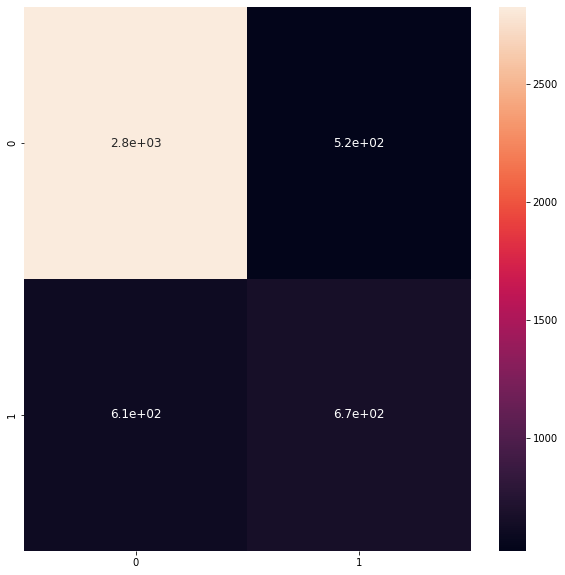

In [188]:
# Plot confusion matrix of results
cm = confusion_matrix(y_test_split, y_preds)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()